In [1]:
from pytorch_lightning.loggers import CometLogger

import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl
from kornia.utils import create_meshgrid
from torch.utils.data import DataLoader, TensorDataset
from einops import rearrange
from torchvision.io import read_image
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from collections import OrderedDict
from kornia.augmentation import RandomAffine, CenterCrop
import cv2 as cv


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
class Homography(nn.Module):
    def __init__(self):
        super().__init__()
        self.H = torch.nn.Parameter(torch.zeros(8))
        #self.register_parameter(name='H', param=torch.nn.Parameter(torch.randn(8)))

    def sl3_to_SL3(self,h):
        # homography: directly expand matrix exponential
        # https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.61.6151&rep=rep1&type=pdf
        h1,h2,h3,h4,h5,h6,h7,h8 = h.chunk(8,dim=-1)
        A = torch.stack([torch.cat([h5,h3,h1],dim=-1),
                         torch.cat([h4,-h5-h6,h2],dim=-1),
                         torch.cat([h7,h8,h6],dim=-1)],dim=-2)
        H = A.matrix_exp()
        return H



    def forward(self, x):
        H = self.sl3_to_SL3(self.H)
        return H@x


class NeuralRenderer(nn.Module):
    def __init__(self, pos_enc = False, L = 10):
        super().__init__()
        self.pos_enc = pos_enc
        self.L = L

        if pos_enc:
            input_size = 2*2*L
        else:
            input_size = 2

        self.input_layer = nn.Linear(input_size,256)
        self.hidden = nn.Sequential(*[nn.Linear(256,256), nn.ReLU()]*6)
        self.output_layer = nn.Linear(256,3)

    def positional_encoding(self, input, L): # [B,...,N]
        shape = input.shape
        freq = 2**torch.arange(L,dtype=torch.float32).to(input.device)*np.pi # [L]
        spectrum = input[...,None]*freq # [B,...,N,L]
        sin,cos = spectrum.sin(),spectrum.cos() # [B,...,N,L]
        input_enc = torch.stack([sin,cos],dim=-2) # [B,...,N,2,L]
        input_enc = input_enc.view(*shape[:-1],-1) # [B,...,2NL]
        # coarse-to-fine: smoothly mask positional encoding for BARF
        return input_enc

    def forward(self, x):
        if self.pos_enc:
            x = self.positional_encoding(x, self.L)

        x = F.relu(self.input_layer(x))
        x = self.hidden(x)
        x = self.output_layer(x)
        return x


class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
class PixelData(pl.LightningDataModule):
    def __init__(self, img_path, batch_size: int = 32):
        super().__init__()
        self.batch_size = batch_size

        img = read_image(img_path, torchvision.io.ImageReadMode.RGB)/255.
        C,H,W = img.size()
        img = rearrange(img,'c H W -> (H W) c')


        coords = create_meshgrid(H,W)
        coords = rearrange(coords,'b h w c -> (b h w) c')
        self.data  = TensorDataset(coords, img)
        self.dataloader = DataLoader(self.data, batch_size=H*W)


    def train_dataloader(self):
        return self.dataloader

    def val_dataloader(self):
        return self.dataloader

    def test_dataloader(self):
        return self.dataloader


class NeuralRendererPL(pl.LightningModule):
    def __init__(self, img_path, pos_enc=False, L=10, video_file = "output.avi"):
        super().__init__()
        #self.mlp = NeuralRenderer(True)
        
        self.L = L
        self.pos_enc = pos_enc
        if pos_enc:
            input_size = 2*2*L
        else:
            input_size = 2

        self.mlp = Siren(in_features=input_size, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
        self.loss = nn.L1Loss()

        img = read_image(img_path, torchvision.io.ImageReadMode.RGB)/255.
        self.img = img

        C,H,W = img.size()
        
        self.out = cv.VideoWriter( video_file, cv.VideoWriter_fourcc('M','J','P','G'), 3, (W,H))

        img = rearrange(img,'c H W -> (H W) c')


        coords = create_meshgrid(H,W)
        self.coords = rearrange(coords,'b h w c -> (b h w) c')
        self.data  = TensorDataset(self.coords, img)
        self.dataloader = DataLoader(self.data, batch_size=H*W,pin_memory=True)

    def forward(self, x):

        if self.pos_enc:
            x = self.positional_encoding(x)

        return self.mlp(x)[0]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000)
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        return self.dataloader

    def val_dataloader(self):
        return self.dataloader

    def positional_encoding(self, input): # [B,...,N]
        L = self.L
        shape = input.shape
        freq = 2**torch.arange(L,dtype=torch.float32).to(input.device)*np.pi # [L]
        spectrum = input[...,None]*freq # [B,...,N,L]
        sin,cos = spectrum.sin(),spectrum.cos() # [B,...,N,L]
        input_enc = torch.stack([sin,cos],dim=-2) # [B,...,N,2,L]
        input_enc = input_enc.view(*shape[:-1],-1) # [B,...,2NL]
        # coarse-to-fine: smoothly mask positional encoding for BARF
        return input_enc

    def training_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        
        self.log('loss', loss.item())

        return loss

    def render_image(self):
        
        C,H,W = self.img.size()
        x = create_meshgrid(H,W).squeeze().to(self.device)
        x = rearrange(x,'H W C -> (H W) C')
        y = self(x)
        y = rearrange(y, '(H W) C -> C H W ', H=H,W=W)    
        return y

    def on_train_epoch_end(self):
        
        if self.current_epoch % 10 == 0:
            y = self.render_image()
            
            frame = rearrange(y, 'C H W -> H W C')    
            frame = frame.detach().cpu().numpy()
            frame = 255*frame
            frame = frame.astype(np.uint8)[:,:,::-1]
            self.out.write(frame)
            show([self.img,y])
            plt.show()


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:115: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mlp  | Siren  | 198 K 
1 | loss | L1Loss | 0     
--------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.796     Total estimated model params size (MB)
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dat

Training: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/semjon/barf/185b6965522c42c19111322d611f319e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [125] : (0.04349566996097565, 0.3736191987991333)
COMET INFO:   Others:
COMET INFO:     Name : BARF
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1


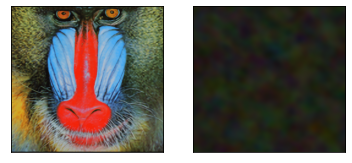

/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [42]:
COMET_ML_PROJECT = "barf"
torch.cuda.empty_cache()
experiment_name = "BARF"
    

comet_logger = CometLogger(
    api_key="tMEjeyq5M7v1IPRCvS5fyGyuo",
    workspace="semjon", # Optional
    project_name= COMET_ML_PROJECT, # Optional
    # rest_api_key=os.environ["COMET_REST_KEY"], 
    #save_dir='./segmentation',
    experiment_name=experiment_name, # Optional,
    #display_summary_level = 0
)


model = NeuralRendererPL("baboon.png", pos_enc=False)
trainer = pl.Trainer(accelerator="gpu", logger=comet_logger,log_every_n_steps=1, max_epochs=1000)
trainer.fit(model)
model.out.release()

# Apply Homography

In [4]:
H = torch.tensor([[1.0, 0, 0.5],
                 [0, 1.0, 0.5],
                 [0, 0, 1]]).to(model.device)
H_inv = torch.linalg.inv(H)

C,H,W = model.img.size()
x = create_meshgrid(H,W).squeeze().to(model.device)
ones = torch.ones((H,W,1)).to(model.device)
x_hom = torch.concat([x,ones], dim=2)
x_hom = rearrange(x_hom,'H W C -> (H W) C')

x_hom = (H_inv@x_hom.T).T

x_euc = x_hom/x_hom[:,2:]
y = model(x_euc[:,:2])
y = rearrange(y, '(H W) C -> C H W ', H=H,W=W)    
show([model.img,y])
plt.show()

NameError: name 'model' is not defined

In [46]:
def get_coords_dataloader(img):
    C,H,W = img.size()
    img = rearrange(img,'c H W -> (H W) c')

    x = create_meshgrid(H,W).squeeze()
    ones = torch.ones((H,W,1))
    x_hom = torch.concat([x,ones], dim=2)
    x_hom = rearrange(x_hom,'H W C -> (H W) C')
    dataset  = TensorDataset(x_hom, img)
    dataloader = DataLoader(dataset, batch_size=H*W)
    return dataloader
    

class BARF_PL(pl.LightningModule):
    def __init__(self, img, imgs, coords, pos_enc=False, L=10, barf_c2f = True, video_file = "output.avi"):
        super().__init__()
        #self.mlp = NeuralRenderer(True)
        
        # Positional Encoding
        self.L = L
        self.pos_enc = pos_enc
        self.barf_c2f = barf_c2f
        if pos_enc:
            input_size = 2*2*L
        else:
            input_size = 2
            
            
        self.img = img

        # MLP-Model (SIREN)
        self.mlp = Siren(in_features=input_size, out_features=3, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
        
        # Loss
        self.loss = nn.L1Loss()
        
        # Images 
        self.imgs = imgs
        img = imgs[0]
        C,H,W = img.size()
        
         # Coordinates
        ones = torch.ones((H,W,1))
        #x_hom = torch.concat([coords,ones], dim=2)
        x_hom = rearrange(coords,'H W C -> (H W) C')
        rgb = rearrange(img,'c H W -> (H W) c')
        dataset  = TensorDataset(x_hom, rgb)
        dataloader = DataLoader(dataset, batch_size=H*W)
        self.dataloader_ref = dataloader
        
        # Homographies
        self.homographies = nn.ModuleList([Homography() for _ in imgs])
        
        # Video Writer
        self.out = cv.VideoWriter( video_file, cv.VideoWriter_fourcc('M','J','P','G'), 3, (W,H))


    def forward(self, x):
        x = x.clone().detach().requires_grad_(True)
        if self.pos_enc:
            x = self.positional_encoding(x)

        return self.mlp(x)[0]

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000)
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        loaders = [self.dataloader_ref] + [get_coords_dataloader(img) for img in imgs[1:]]
        return loaders

    def val_dataloader(self):
        return self.dataloader

    def positional_encoding(self, input): # [B,...,N]
        L = self.L
        shape = input.shape
        freq = 2**torch.arange(L,dtype=torch.float32).to(input.device)*np.pi # [L]
        spectrum = input[...,None]*freq # [B,...,N,L]
        sin,cos = spectrum.sin(),spectrum.cos() # [B,...,N,L]
        input_enc = torch.stack([sin,cos],dim=-2) # [B,...,N,2,L]
        input_enc = input_enc.view(*shape[:-1],-1) # [B,...,2NL]
        
        # coarse-to-fine: smoothly mask positional encoding for BARF
        if self.barf_c2f:
            # set weights for different frequency bands
            start,end = 0,self.trainer.max_epochs
            progress = self.current_epoch
      
            alpha = (progress-start)/(end-start)*L
            k = torch.arange(L,dtype=torch.float32,device=input.device)
            weight = (1-(alpha-k).clamp_(min=0,max=1).mul_(np.pi).cos_())/2
            # apply weights
            shape = input_enc.shape
            input_enc = (input_enc.view(-1,L)*weight).view(*shape)
            
        return input_enc

    def training_step(self, batch, batch_idx):
        
        
        x,y = batch[0]
        x = x.clone().detach().requires_grad_(True)

        x_euc = x/x[:,2:]
        y_hat = self(x_euc[:,:2])
        loss = self.loss(y_hat, y)

        for i in range(1,len(self.imgs)):
            
            (x,y), H = batch[i], self.homographies[i]
            x = x.clone().detach().requires_grad_(True)
            print(H.H.is_leaf)
            x_hom = (H(x.T)).T
            x_euc = x_hom/x_hom[:,2:]
            y_hat = self(x_euc[:,:2])
            loss += self.loss(y_hat, y)
        
        self.log('loss', loss.item())
        return loss

    def render_image(self, T):
        
        C,H,W = self.img.size()
        x = create_meshgrid(H,W).squeeze().to(self.device)
        
        ones = torch.ones((H,W,1)).to(self.device)
        x = torch.concat([x,ones], dim=2)
        x = rearrange(x,'H W C -> (H W) C')

        x_hom = (T(x.T)).T
        x_euc = x_hom/x_hom[:,2:]
        y = self(x_euc[:,:2])

        y = rearrange(y, '(H W) C -> C H W ', H=H,W=W)    
        

        return y

    def on_train_epoch_end(self):
        
        if self.current_epoch % 10 == 0:
            results = []
            for i,T in enumerate(self.homographies):
                y = self.render_image(T)
                results.append(y)

                frame = rearrange(y, 'C H W -> H W C')    
                frame = frame.detach().cpu().numpy()
                frame = 255*frame
                frame = frame.astype(np.uint8)[:,:,::-1]
                if i == 0:
                    self.out.write(frame)
            show(results)
            plt.show()
            
    def on_after_backward(self):
        # example to inspect gradient information in tensorboard
        if self.trainer.global_step % 25 == 0:  # don't make the tf file huge
            params = self.state_dict()
            for k, v in params.items():
                grads = v
                name = k
                if name.startswith("homographies"):
                    print(name)
                    print(grads, v.grad)

                #self.logger.log_histogram(tag="grads", values=grads, global_step=self.trainer.global_step)

torch.Size([3, 250, 250])
torch.Size([3, 250, 250])


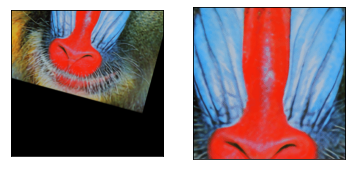

In [36]:
img = read_image("baboon.png", torchvision.io.ImageReadMode.RGB)/255.
aug = RandomAffine((-15., 20.), (0,0.5), p=1.)
center =  CenterCrop((250,250))

C,H,W = img.size()
x = create_meshgrid(H,W).squeeze()
ones = torch.ones((H,W,1))
x_hom = torch.concat([x,ones], dim=2)
x_hom = rearrange(x_hom,'H W C -> C H W')

img_hom = aug(img[None,:],).squeeze()
img_center = center(img[None,:],).squeeze()

print(center(x_hom).squeeze().size())
print(img_center.size())
show([img_hom,img_center])

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:115: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | mlp          | Siren      | 208 K 
1 | loss         | L1Loss     | 0     
2 | homographies | ModuleList | 16    
--------------------------------------------
208 K     Trainable params
0         Non-trainable params
208 K     Total params
0.835     Total estimated model params size (MB)
/home/monika/anaconda3/envs/ML/lib/python3.9/site-packages/pytorch

Training: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/semjon/barf/3e5032d4821f44d6a5a467049468091a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [4] : (0.5169126987457275, 0.7878686785697937)
COMET INFO:   Others:
COMET INFO:     Name : BARF
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COM

True
homographies.0.H
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') None
homographies.1.H
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') None


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/semjon/barf/e9ec0bdc45ef48ee8f8166a231623644



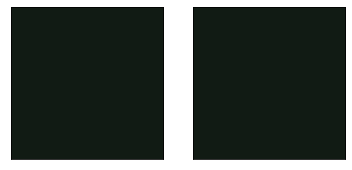

True
True
True
True
True
True
True
True


In [ ]:
imgs = [img_center,img_hom]
coords_ref = center(x_hom).squeeze()
coords_ref = rearrange(coords_ref,'C H W -> H W C')


COMET_ML_PROJECT = "barf"
torch.cuda.empty_cache()
experiment_name = "BARF"
    

comet_logger = CometLogger(
    api_key="tMEjeyq5M7v1IPRCvS5fyGyuo",
    workspace="semjon", # Optional
    project_name= COMET_ML_PROJECT, # Optional
    # rest_api_key=os.environ["COMET_REST_KEY"], 
    #save_dir='./segmentation',
    experiment_name=experiment_name, # Optional,
    #display_summary_level = 0
)

img = img_center
imgs = [img_center, img_hom]

model = BARF_PL(img, imgs,coords_ref, pos_enc=True).cuda()
trainer = pl.Trainer(accelerator="gpu", logger=comet_logger,log_every_n_steps=1, max_epochs=3000)
trainer.fit(model)
model.out.release()

In [177]:
model.homographies[0].H

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)